# Methodology Overview

This notebook implements a pipeline for forecasting multi-asset returns and constructing optimized portfolios via Markowitz and Black–Litterman approaches. The main steps are:

1. **Data Collection**  
   - Downloaded OHLCV price data for target tickers (SPY, MSFT, META, AAPL, NVDA, TSLA) via Yahoo Finance.  
   - Retrieved macroeconomic factors (VIX index, 10-year Treasury yield) from FRED and derived momentum features.

2. **Feature Engineering**  
   - **Basic Technical Indicators**: 10/30/50-day simple moving averages (SMA), 14-day RSI, 12/26-day MACD and signal line.  
   - **Extended Indicators**: daily range ratio, 14-day ATR, 10-day volume moving average, on-balance volume (OBV).  
   - **Macro Factors**: VIX level and 5-day momentum, 10-year yield and 5-day momentum.

3. **Label Construction**  
   - Computed rolling cumulative log-returns over a fixed horizon (5-day by default) as the target to forecast.

   (We actually did an ablation experiment comparing performance across different horizons in[1,5,10] and 5-day results outperforms the other two. Since the training process is identical, instead of showing the experiment in the code snippets, we choose to write a simple illustration here.)

4. **Data Preparation**  
   - Aligned stock features, macro factors, and forward returns on common dates.  
   - Generated sliding windows of length _window_ (20 days) for both stock and macro inputs.
   - Split into training and testing sets (80% / 20% sequentially) and applied standard scaling.

5. **Modeling**  
   - Built a dual‐branch LSTM model: 64-unit LSTM on stock features and 32-unit LSTM on macro factors, merged via concatenation, followed by dense layers.  
   - Trained with MSE loss to predict multi‐output returns simultaneously.

6. **Forecast & Portfolio Construction**  
   - Predicted next‐5‐day cumulative log‐returns for each asset.  
   - **Markowitz**: maximized Sharpe ratio under long-only fully invested constraint.  
   - **Black–Litterman**: inferred equilibrium returns from market caps, blended with LSTM forecasts as views, then optimized for Sharpe ratio.

7. **Evaluation & Visualization**  
   - Backtested out‐of‐sample cumulative portfolio returns.  
   - Plotted performance metrics (annual return, volatility, Sharpe, Sortino, Calmar) on a radar chart.  
   - Visualized sample technical indicators (SMA, RSI, MACD, ATR, OBV) for SPY.

---

# Feature Definitions

| Feature            | Description                                                       |
|--------------------|-------------------------------------------------------------------|
| `Close_sma10`      | 10-day simple moving average of closing price                     |
| `Close_sma30`      | 30-day simple moving average                                      |
| `Close_rsi14`      | 14-day Relative Strength Index: momentum oscillator                |
| `Close_macd`       | Difference between 12-day EMA and 26-day EMA                      |
| `Close_macd_sig`   | 9-day EMA of the `macd` line                                      |
| `range`            | `(High - Low) / Open`: normalized daily price range                |
| `atr14`            | 14-day Average True Range: volatility measure                     |
| `vol_ma10`         | 10-day moving average of volume                                   |
| `obv`              | On-balance volume: cumulative signed volume trend                  |
| `M_VIX`            | VIX index level                                                   |
| `M_VIX_mom5`       | 5-day momentum of VIX                                             |
| `M_10Y`            | 10-year Treasury yield                                            |
| `M_10Y_mom5`       | 5-day momentum of 10-year yield                                   |

*All features are aligned by trading date. Rolling-window inputs consist of the past 20 days of each feature for model training.*



In [ ]:
# -*- coding: utf-8 -*-
import warnings
warnings.filterwarnings('ignore')

# 1. Set random seed
import random
import numpy as np
import tensorflow as tf
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

import pandas as pd
from datetime import datetime
from pandas_datareader import data as web
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, concatenate
import scipy.optimize as sco
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [ ]:
# 2. Parameter settings
tickers = ["SPY","MSFT","META","AAPL","NVDA","TSLA"]
horizon = 5  # 5-day forecast
window = 20

delta = 2.5   # Black–Litterman risk aversion
tau = 0.05    # BL scaling factor
conf = 0.5    # BL view confidence
start = "2015-04-15"
end = datetime.today().strftime("%Y-%m-%d")

# 3. Download price and macro data
raw = yf.download(tickers, start=start, end=end, auto_adjust=False, progress=False)
close = raw["Close"].dropna()
# Macro factors
vix = web.DataReader("VIXCLS","fred", start, end)
t10yr = web.DataReader("DGS10","fred", start, end) / 100.0
macro = pd.concat([vix.rename(columns={"VIXCLS":"VIX"}), t10yr.rename(columns={"DGS10":"10Y"})], axis=1).dropna()
macro["VIX_mom5"] = macro["VIX"].diff(5)
macro["10Y_mom5"] = macro["10Y"].diff(5)
feat_macro = macro.add_prefix("M_")

In [ ]:
# 4. Feature engineering
def add_basic(df):
    df = df.copy()
    df["sma10"] = df["Close"].rolling(10).mean()
    df["sma30"] = df["Close"].rolling(30).mean()
    delta = df["Close"].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    df["rsi14"] = 100 - 100/(1 + gain.rolling(14).mean()/loss.rolling(14).mean())
    ema12 = df["Close"].ewm(span=12).mean()
    ema26 = df["Close"].ewm(span=26).mean()
    df["macd"] = ema12 - ema26
    df["macd_sig"] = df["macd"].ewm(span=9).mean()
    return df.dropna()

def add_ext(df):
    df = df.copy()
    df["range"] = (df["High"] - df["Low"]) / df["Open"]
    high_low = df["High"] - df["Low"]
    high_prev = (df["High"] - df["Close"].shift()).abs()
    low_prev = (df["Low"] - df["Close"].shift()).abs()
    df["atr14"] = pd.concat([high_low, high_prev, low_prev], axis=1).max(axis=1).rolling(14).mean()
    df["vol_ma10"] = df["Volume"].rolling(10).mean()
    df["obv"] = (np.sign(df["Close"].diff()) * df["Volume"]).cumsum()
    return df.dropna()

# Aggregate features for all tickers
feat_list = []
for t in tickers:
    df_t = raw.xs(t, axis=1, level=1)[["Open","High","Low","Close","Volume"]].dropna()
    basic = add_basic(df_t[["Close"]])
    ext = add_ext(df_t)
    feat = pd.concat([basic, ext], axis=1)
    feat.columns = [f"{t}_{c}" for c in feat.columns]
    feat_list.append(feat)
feat_stocks = pd.concat(feat_list, axis=1).dropna()

In [ ]:
# 5. Build labels and sliding windows
lab = np.log(close).diff().rolling(horizon).sum().shift(-horizon).dropna()
idx = feat_stocks.index.intersection(feat_macro.index).intersection(lab.index)
df_all = pd.concat([feat_stocks.loc[idx], feat_macro.loc[idx], lab.loc[idx]], axis=1).dropna()

def seq(X_df, M_df, Y_df, w):
    Xs, Ms, Ys = [], [], []
    for i in range(len(X_df) - w):
        Xs.append(X_df.iloc[i:i+w].values)
        Ms.append(M_df.iloc[i:i+w].values)
        Ys.append(Y_df.iloc[i+w])
    return np.array(Xs), np.array(Ms), np.array(Ys)

X, M, Y = seq(df_all[feat_stocks.columns], df_all[feat_macro.columns], df_all[tickers], window)

In [ ]:

# 6. Train/test split and scaling
X_tr, X_te, M_tr, M_te, y_tr, y_te = train_test_split(X, M, Y, test_size=0.2, shuffle=False)
scX = StandardScaler().fit(X_tr.reshape(-1, X_tr.shape[2]))
scM = StandardScaler().fit(M_tr.reshape(-1, M_tr.shape[2]))
def scale(a, s): return s.transform(a.reshape(-1, a.shape[2])).reshape(a.shape)
X_tr_s, X_te_s = scale(X_tr, scX), scale(X_te, scX)
M_tr_s, M_te_s = scale(M_tr, scM), scale(M_te, scM)


In [71]:
# 7. LSTM model definition
inp_s = Input(shape=(window, X_tr_s.shape[2]), name="stock_input")
x1 = LSTM(64)(inp_s)
x1 = Dropout(0.2)(x1)
inp_m = Input(shape=(window, M_tr_s.shape[2]), name="macro_input")
x2 = LSTM(32)(inp_m)
x = concatenate([x1, x2])
x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)
out = Dense(len(tickers), activation="linear", name="returns")(x)
model = Model(inputs=[inp_s, inp_m], outputs=out)
model.compile(optimizer="adam", loss="mse")
history = model.fit(
    [X_tr_s, M_tr_s], y_tr,
    validation_data=([X_te_s, M_te_s], y_te),
    epochs=20, batch_size=32, verbose=1
)

Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.0398 - val_loss: 0.0118
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0054 - val_loss: 0.0088
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0034 - val_loss: 0.0066
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0031 - val_loss: 0.0072
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0029 - val_loss: 0.0058
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0028 - val_loss: 0.0070
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0028 - val_loss: 0.0071
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0027 - val_loss: 0.0062
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0027 - val_loss: 0.0058
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0026 - val_loss: 0.0047
Epoch 11/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0026 - val_loss: 0.0059
Epoch 12/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0

In [72]:
# 8. Forecast and portfolio optimization
y_pred = model.predict([X_te_s, M_te_s])[-1]
mu_hat = pd.Series(y_pred, index=tickers).sort_values(ascending=False)
print(f"{horizon}-day cumulative log-return forecast:")
print(mu_hat.round(4))

rets_all = close.pct_change().dropna()
rets_test = rets_all.iloc[-len(Y):]
Sigma = rets_test.cov() * 252
mu_simple = np.exp(mu_hat) - 1

def neg_sharpe(w, mu, cov):
    return - (w.dot(mu)) / np.sqrt(w.dot(cov).dot(w))

n = len(tickers)
w0 = np.ones(n) / n
bounds = [(0,1)] * n
constraints = {"type":"eq", "fun":lambda w: w.sum() - 1}
res_mk = sco.minimize(
    neg_sharpe, w0,
    args=(mu_simple.values, Sigma.values),
    bounds=bounds, constraints=constraints
)
w_mk = pd.Series(res_mk.x, index=tickers)

caps = {t: yf.Ticker(t).info.get("marketCap", np.nan) for t in tickers}
w_mkt = pd.Series(caps)
w_mkt /= w_mkt.sum()
pi = delta * Sigma.dot(w_mkt)
P = np.eye(n)
Q = mu_simple.values
Omega = np.diag(tau * np.diag(Sigma)) / conf
A = np.linalg.inv(tau * Sigma.values) + P.T.dot(np.linalg.inv(Omega)).dot(P)
b = np.linalg.inv(tau * Sigma.values).dot(pi) + P.T.dot(np.linalg.inv(Omega)).dot(Q)
mu_bl = pd.Series(np.linalg.inv(A).dot(b), index=tickers)
res_bl = sco.minimize(
    neg_sharpe, w0,
    args=(mu_bl.values, Sigma.values),
    bounds=bounds, constraints=constraints
)
w_bl = pd.Series(res_bl.x, index=tickers)

print("Markowitz weights:\n", w_mk.round(3))
print("Black–Litterman weights:\n", w_bl.round(3))

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
5-day cumulative log-return forecast:
AAPL    0.0386
SPY     0.0284
NVDA   -0.0172
TSLA   -0.0208
MSFT   -0.0416
META   -0.0733
dtype: float32
Markowitz weights:
 SPY     0.974
MSFT    0.026
META    0.000
AAPL    0.000
NVDA    0.000
TSLA    0.000
dtype: float64
Black–Litterman weights:
 SPY     0.500
MSFT    0.155
META    0.000
AAPL    0.345
NVDA    0.000
TSLA    0.000
dtype: float64


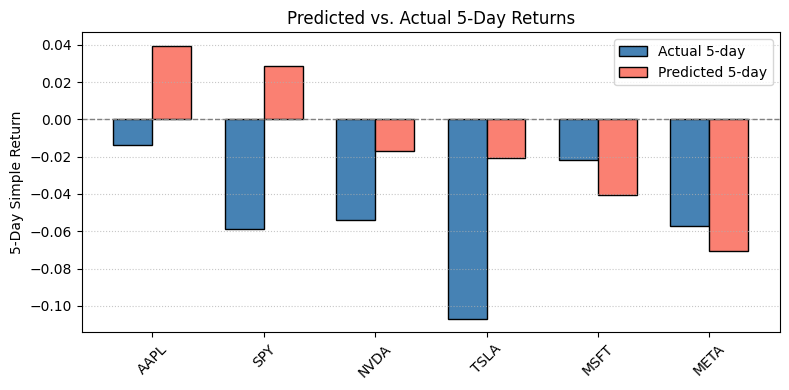

In [74]:
# --- Snippet: compare predicted vs actual 5-day returns ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# already have:
#   y_pred    = model.predict([X_te_s, M_te_s])[-1]      # predicted log-returns (shape=(n_tickers,))
#   tickers   = list of your symbols
#   horizon   = 5
#   stock     = full 'Close' DataFrame from yf.download
#   X_te_idx  = list or Index of dates corresponding to your X_te windows

# 1. Recover the test‐window end dates
#    If built X/M/Y via:
#       X, M, Y = seq(df_stocks, df_macro, lab, window)
#       X_tr,X_te,... = train_test_split(...)
#    then X_te corresponds to the last len(X_te) windows; their end dates are:
end_dates = df_all.index[ window : ][ -len(X_te_s): ]  # df_all is your features+lab

# 2. Get the true 5-day cumulative log-return for each ticker on those end dates
true_log5 = lab.loc[end_dates].values  # shape = (n_test_samples, n_tickers)
true_last = true_log5[-1]             # the very last test sample

# 3. Convert log-returns to simple returns
pred_simple = np.exp(y_pred) - 1
true_simple = np.exp(true_last) - 1

# 4. Build Series for easy plotting
pred_s = pd.Series(pred_simple, index=tickers).sort_values(ascending=False)
true_s = pd.Series(true_simple, index=pred_s.index)

# 5. Plot side-by-side bar chart
fig, ax = plt.subplots(figsize=(8,4))
width = 0.35
x = np.arange(len(tickers))

ax.bar(x - width/2, true_s.values, width, label='Actual 5-day', color='steelblue', edgecolor='k')
ax.bar(x + width/2, pred_s.values, width, label='Predicted 5-day', color='salmon',   edgecolor='k')
ax.axhline(0, color='gray', linestyle='--', linewidth=1)

ax.set_xticks(x)
ax.set_xticklabels(pred_s.index, rotation=45)
ax.set_ylabel('5-Day Simple Return')
ax.set_title('Predicted vs. Actual 5-Day Returns')
ax.legend()
ax.grid(axis='y', linestyle=':', alpha=0.7)

plt.tight_layout()
plt.show()


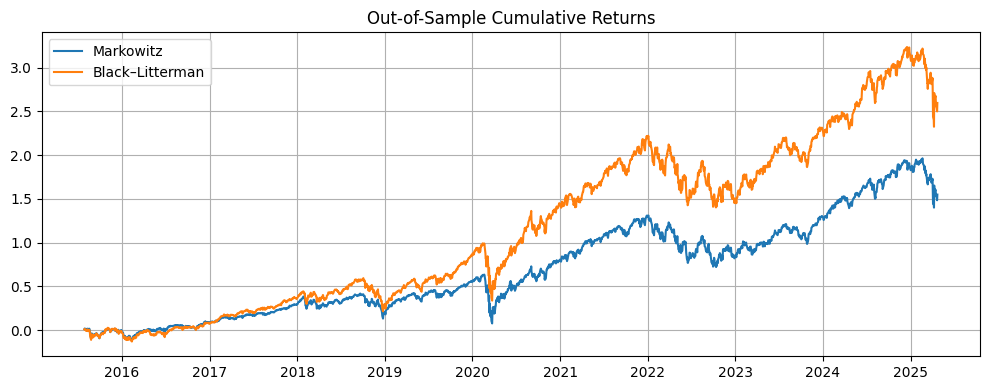

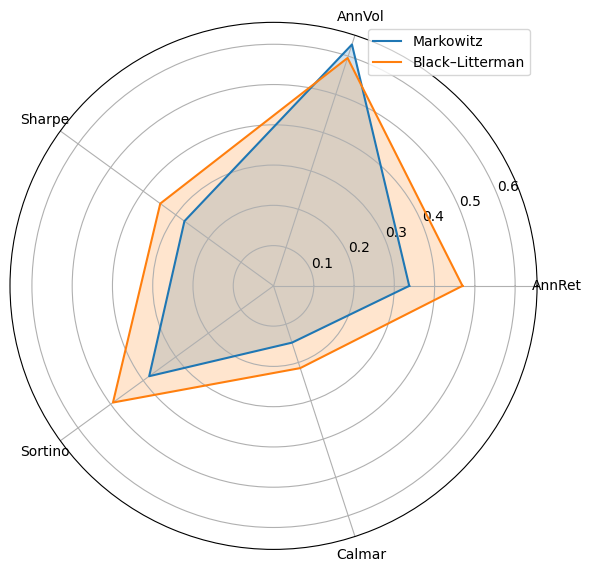

In [69]:

# 9. Visualization
# 9a. Cumulative returns backtest
port_mk = rets_test.mul(w_mk, axis=1).sum(axis=1)
port_bl = rets_test.mul(w_bl, axis=1).sum(axis=1)
plt.figure(figsize=(10,4))
plt.plot((1+port_mk).cumprod()-1, label="Markowitz")
plt.plot((1+port_bl).cumprod()-1, label="Black–Litterman")
plt.title("Out-of-Sample Cumulative Returns")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 9b. Performance radar plot
perf = {}
cols = ["AnnRet","AnnVol","Sharpe","Sortino","Calmar"]
for name, w in [("Markowitz", w_mk), ("Black–Litterman", w_bl)]:
    p = rets_test.mul(w, axis=1).sum(axis=1)
    ann_ret = (1+p).prod()**(252/len(p)) - 1
    ann_vol = p.std() * np.sqrt(252)
    downside = p.copy(); downside[downside>0] = 0
    dvol = np.sqrt((downside**2).mean()) * np.sqrt(252)
    sortino = ann_ret / dvol if dvol>0 else np.nan
    cum = (1+p).cumprod()
    mdd = ((cum.cummax()-cum)/cum.cummax()).max()
    calmar = ann_ret / mdd if mdd>0 else np.nan
    sharpe = ann_ret / ann_vol if ann_vol>0 else np.nan
    perf[name] = [ann_ret, ann_vol, sharpe, sortino, calmar]
perf_df = pd.DataFrame(perf, index=cols).T
ranges = {"AnnRet":0.3, "AnnVol":0.5, "Sharpe":2, "Sortino":2, "Calmar":2}
norm_df = perf_df.copy()
for c, m in ranges.items():
    norm_df[c] = perf_df[c]/m if c!="AnnVol" else 1 - perf_df[c]/m
angles = np.linspace(0,2*np.pi,len(cols),endpoint=False).tolist() + [0]
fig, ax = plt.subplots(subplot_kw={"polar":True}, figsize=(6,6))
for name, row in norm_df.iterrows():
    vals = row.tolist() + [row.iloc[0]]
    ax.plot(angles, vals, label=name)
    ax.fill(angles, vals, alpha=0.2)
ax.set_thetagrids(np.degrees(angles[:-1]), cols)
# ax.set_title("Performance Radar")
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()



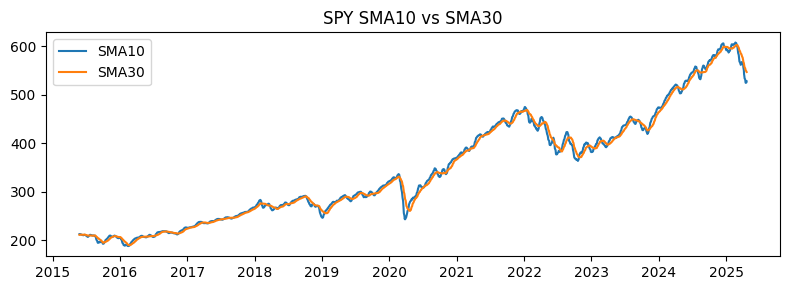

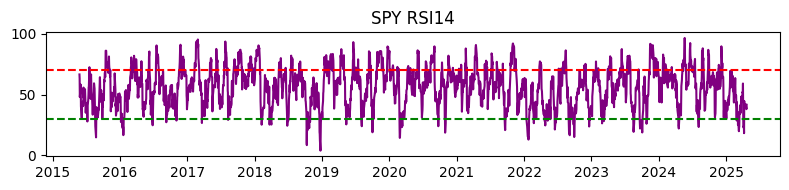

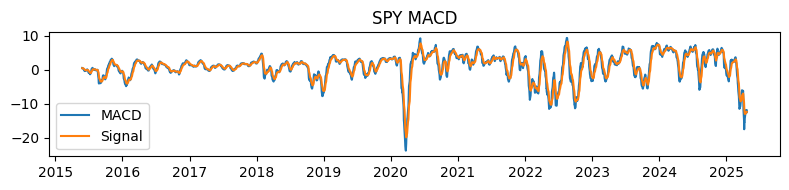

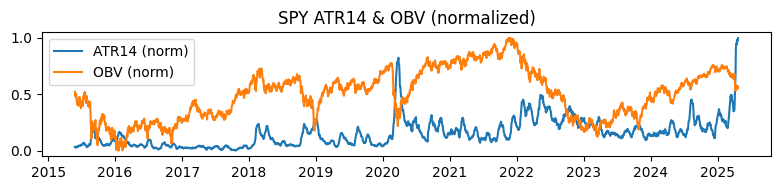

In [73]:
# 10. Feature visualization for SPY
sample = "SPY"
df_spy = feat_stocks.filter(like=sample)
plt.figure(figsize=(8,3))
plt.plot(df_spy[f"{sample}_sma10"], label="SMA10")
plt.plot(df_spy[f"{sample}_sma30"], label="SMA30")
plt.title("SPY SMA10 vs SMA30")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,2))
plt.plot(df_spy[f"{sample}_rsi14"], color="purple")
plt.axhline(70, linestyle="--", color="red")
plt.axhline(30, linestyle="--", color="green")
plt.title("SPY RSI14")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,2))
plt.plot(df_spy[f"{sample}_macd"], label="MACD")
plt.plot(df_spy[f"{sample}_macd_sig"], label="Signal")
plt.title("SPY MACD")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,2))
atr_norm = (df_spy[f"{sample}_atr14"] - df_spy[f"{sample}_atr14"].min()) / (df_spy[f"{sample}_atr14"].max() - df_spy[f"{sample}_atr14"].min())
obv_norm = (df_spy[f"{sample}_obv"] - df_spy[f"{sample}_obv"].min()) / (df_spy[f"{sample}_obv"].max() - df_spy[f"{sample}_obv"].min())
plt.plot(atr_norm, label="ATR14 (norm)")
plt.plot(obv_norm, label="OBV (norm)")
plt.title("SPY ATR14 & OBV (normalized)")
plt.legend()
plt.tight_layout()
plt.show()


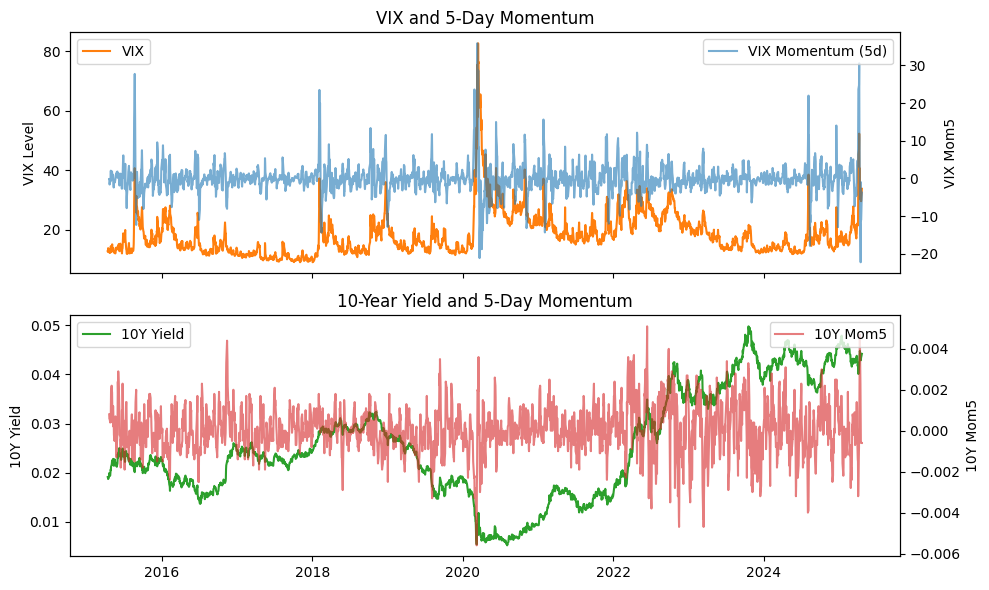

In [75]:
# 11. Macro feature visualization
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# 11a. VIX level and 5-day momentum
axes[0].plot(feat_macro.index, feat_macro["M_VIX"], label="VIX", color="tab:orange")
axes[0].set_ylabel("VIX Level")
ax2 = axes[0].twinx()
ax2.plot(feat_macro.index, feat_macro["M_VIX_mom5"], label="VIX Momentum (5d)", color="tab:blue", alpha=0.6)
ax2.set_ylabel("VIX Mom5")
axes[0].set_title("VIX and 5-Day Momentum")
axes[0].legend(loc="upper left")
ax2.legend(loc="upper right")

# 11b. 10-Year Treasury yield and 5-day momentum
axes[1].plot(feat_macro.index, feat_macro["M_10Y"], label="10Y Yield", color="tab:green")
axes[1].set_ylabel("10Y Yield")
ax4 = axes[1].twinx()
ax4.plot(feat_macro.index, feat_macro["M_10Y_mom5"], label="10Y Mom5", color="tab:red", alpha=0.6)
ax4.set_ylabel("10Y Mom5")
axes[1].set_title("10-Year Yield and 5-Day Momentum")
axes[1].legend(loc="upper left")
ax4.legend(loc="upper right")

plt.xlabel("Date")
plt.tight_layout()
plt.show()
